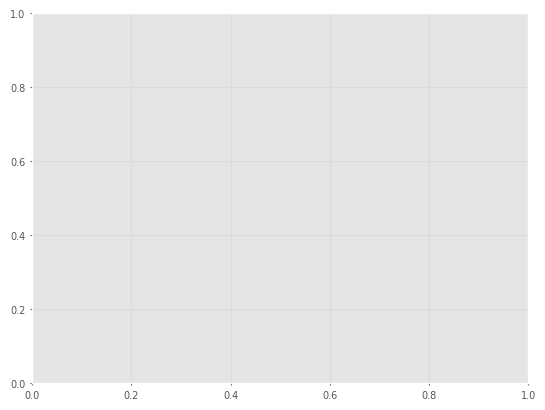

In [1]:

from datetime import datetime
from pathlib import Path
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import numpy as np
from PIL import Image, ImageFilter
import cv2
import random
import roboticstoolbox as rtb
from roboticstoolbox import DistanceTransformPlanner
from roboticstoolbox import Bicycle, RandomPath
import math
from spatialmath.base import *
from math import sin, cos, atan2, radians
from random import uniform

from threading import Timer
from scipy.interpolate import CubicSpline
from numpy.typing import ArrayLike
from easy_trilateration.model import *
from easy_trilateration.least_squares import easy_least_squares
from easy_trilateration.graph import *
from tqdm import tqdm
import yaml
import os


from Vehicle import Vehicle



In [2]:
pwd

'/Users/lz/Codes/Trajectory_Tracking_via_MCAN'

In [4]:

# import timeout_decorator #pip install timeout-decorator
# @timeout_decorator.timeout(60)
F_YES = False


def processMap(map_path, scale_percent):
    img = np.array(Image.open(map_path).convert("L"))
    imgColor = np.array(Image.open(map_path))

    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    imgColor = cv2.resize(imgColor, dim, interpolation=cv2.INTER_AREA)

    imgSharp = cv2.filter2D(img, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    imgdia = np.zeros((np.shape(img)))
    imgdia[img == 255] = 0
    imgdia[img < 255] = 1
    imgdia = cv2.dilate(imgdia, np.ones((1, 1), np.uint8))

    binMap = np.zeros((np.shape(img)))
    binMap[imgSharp < 255] = 0
    binMap[imgSharp == 255] = 1

    return img, imgColor, imgdia, binMap


def findPathsThroughRandomPoints(img, num_locations, outfile):
    if Path(outfile).exists():
        print("random path {outfile} exists, using existing file ...")
        return 1

    free_spaces = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] == 0:
                free_spaces.append((j, i))

    locations = random.choices(free_spaces, k=num_locations)
    # print(locations)

    paths = []
    # for i in range(len(locations) - 1):
    tbar = tqdm(range(len(locations) - 1), disable='GITHUB_ACTIONS' in os.environ)
    tbar.set_description("finding path")
    for i in tbar:
        try:
            dx = DistanceTransformPlanner(
                img, goal=locations[i + 1], distance="euclidean"
            )
            dx.plan()
            path = dx.query(start=locations[i])
        except TimeoutError:
            # locations.append(free_spaces, k=1)
            print("removed a goal")
            continue
        paths.append(path)
        print(f"done {i+1} paths")

    # outfile='./results/testEnvMultiplePathsSeparate_5kmrad_100pdi_0.2line.npy'
    # if exist, rename existing by it's modifuled Ymd-HMS
    if Path.exists(outfile):
        create_time = datetime.fromtimestamp(Path.stat(outfile).st_mtime)
        Path.rename(outfile, outfile + create_time.strftime("%Y%m%d-%H%M%S"))
    np.save(outfile, np.array(paths))

    print(paths)


def remove_consecutive_duplicates(coords):
    # Initialize a new list to store the filtered coordinates
    filtered = []
    # Add the first element to the filtered list
    filtered.append(coords[0])
    # Loop through the remaining elements
    for i in range(1, len(coords)):
        # Check if the current element is different from the previous element
        if coords[i] != coords[i - 1]:
            # If it is, add it to the filtered list
            filtered.append(coords[i])
        # if math.tan((coords[i][1]-coords[i-1][1])/((coords[i][0]-coords[i-1][0])))>= 2*np.pi :

    # Return the filtered list
    return filtered


def rescalePath(paths, path_idx, img, scale, pxlPerMeter):
    # convert path to image
    path_x, path_y = zip(*paths[path_idx])
    pathImg = np.zeros((np.shape(img)))
    pathImg[(path_y, path_x)] = 1

    if scale != 1:
        # scale down path image by given percentage
        width = int(img.shape[1] * scale)
        height = int(img.shape[0] * scale)
        dim = (width, height)
        newImg = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
        pathImgRescaled = cv2.resize(pathImg, dim, interpolation=cv2.INTER_AREA)

    else:
        # newImg = path_idx
        newImg = img
        pathImgRescaled = pathImg

    return (
        [np.round(x * scale) for x in path_x],
        [np.round(y * scale) for y in path_y],
        newImg,
        pathImgRescaled,
        pxlPerMeter * scale,
    )




In [5]:


import os


def rangeSensor(currentPos, landmarks, angleRange, maxDist):
    lndMrkRange = []
    for x, y in landmarks:
        theta = math.atan((currentPos[1] - y) / (currentPos[0] - x + 1e-9))
        dist = math.sqrt((x - currentPos[0]) ** 2 + (y - currentPos[1]) ** 2)

        # if theta > angleRange[0] and theta < angleRange[1]:
        if dist < maxDist:
            # print(theta, dist)
            lndMrkRange.append([dist, theta, x, y])

    return lndMrkRange



def noVisualizationDrive(path_x, path_y, path_img, outfile: Path, frames=1000):
    global velocity, angVel, trueCarPos
    # Storage Variables
    velocity = []
    angVel = []
    trueCarPos = []
    ranges = []
    trilatEstimate = []

    num_landmarks = 80
    xLndMks = np.random.randint(0, np.shape(path_img)[1], num_landmarks)
    yLndMks = np.random.randint(0, np.shape(path_img)[0], num_landmarks)
    landmarks = list(zip(xLndMks, yLndMks))

    # car object
    dt = 0.05
    car = Vehicle(
        path_x,
        path_y,
        100,
        dt,
        control_gain=5,
        softening_gain=0.05,
        yaw_rate_gain=0.5,
        steering_damp_gain=0.0,
        max_steer=np.deg2rad(45),
        c_r=0.1,
        c_a=3.0,
    )

    # for i in range(frames):
    tbar = tqdm(range(frames), desc=f"simulating output to {outfile.name} ", disable='GITHUB_ACTIONS' in os.environ)
    for i in tbar:
        # Drive and draw car
        if (car.px[car.target_id], car.py[car.target_id]) != (car.px[-1], car.py[-1]):
            car.drive()

            """Landmarks"""
            curr_lndMrksRange = rangeSensor(
                [car.x, car.y],
                landmarks,
                [car.yaw - np.deg2rad(60), car.yaw + np.deg2rad(60)],
                200,
            )
            ranges.append(curr_lndMrksRange)

            if len(curr_lndMrksRange) >= 4:
                distances, angles = zip(
                    *[(range[0], range[1]) for range in curr_lndMrksRange]
                )
                x, y = zip(*[(range[2], range[3]) for range in curr_lndMrksRange])
                trilat = [Circle(x[i], y[i], distances[i]) for i in range(len(x))]
                result, meta = easy_least_squares(trilat)
                trilatEstimate.append((result.center.x, result.center.y))
                # print(car.x, car.y, result.center.x, result.center.y)

        else:
            car.v = 0
    car_logs = car.get_logs()
    velocity, angVel, trueCarPos = (
        car_logs["velocity"],
        car_logs["angVel"],
        car_logs["trueCarPos"],
    )
    # outfile=f'./results/TestEnvironmentFiles/TraverseInfo/BerlinEnvPathLandmark{path_idx}.npz'
    start = np.array([path_x[0], path_y[0], car.start_heading])
    # np.savez(outfile,speeds=velocity, angVel=angVel, truePos= trueCarPos, startPose=start)

    np.savez(
        outfile,
        speeds=velocity,
        angVel=angVel,
        truePos=trueCarPos,
        startPose=start,
        landmarks=landmarks,
        # ranges=ranges,
        trilat=trilatEstimate,
        # TODO, Ranges size is differed
        # ranges=np.array(ranges),
        # trilat=np.array(trilatEstimate),
    )


def runSimulation(path_x, path_y, path_img):
    global velocity, angVel, trueCarPos

    def animate(frame):
        global velocity, angVel, trueCarPos
        # Camera tracks car
        ax.set_xlim(car.x - map_size_x, car.x + map_size_x)
        ax.set_ylim(car.y - map_size_y, car.y + map_size_y)

        # Drive and draw car
        if (car.px[car.target_id], car.py[car.target_id]) != (car.px[-1], car.py[-1]):
            car.drive()
            outline_plot, fr_plot, rr_plot, fl_plot, rl_plot = car.plot_car(
                car.x, car.y, car.yaw, car.delta
            )
            car_outline.set_data(*outline_plot)
            front_right_wheel.set_data(*fr_plot)
            rear_right_wheel.set_data(*rr_plot)
            front_left_wheel.set_data(*fl_plot)
            rear_left_wheel.set_data(*rl_plot)
            rear_axle.set_data(car.x, car.y)
        else:
            car.v = 0

        # Show car's target
        target.set_data(car.px[car.target_id], car.py[car.target_id])

        # Annotate car's coordinate above car
        annotation.set_text(f"{car.x:.1f}, {car.y:.1f}")
        annotation.set_position((car.x, car.y + 5))

        plt.title(f"{car.dt*frame:.2f}s", loc="right")
        plt.xlabel(f"Speed: {car.v:.2f} m/s", loc="left")
        # plt.savefig(f'image/visualisation_{frame:03}.png', dpi=300)

        return (
            car_outline,
            front_right_wheel,
            rear_right_wheel,
            front_left_wheel,
            rear_left_wheel,
            rear_axle,
            target,
        )

    # Storage Variables
    velocity = []
    angVel = []
    trueCarPos = []

    # Simulation Parameters
    fps = 20
    dt = 1 / fps
    map_size_x = 70
    map_size_y = 40
    frames = 5000
    loop = False
    car = Vehicle(path_x, path_y, 100, dt)
    interval = car.dt * 10**3

    fig = plt.figure()
    ax = plt.axes()
    ax.set_aspect("equal")

    ax.plot(path_x, path_y, "--", color="gold")
    ax.imshow(path_img, cmap="gray")

    empty = ([], [])
    (target,) = ax.plot(*empty, "+r")
    (car_outline,) = ax.plot(*empty, color="blue")
    (front_right_wheel,) = ax.plot(*empty, color="blue")
    (rear_right_wheel,) = ax.plot(*empty, color="blue")
    (front_left_wheel,) = ax.plot(*empty, color="blue")
    (rear_left_wheel,) = ax.plot(*empty, color="blue")
    (rear_axle,) = ax.plot(car.x, car.y, "+", color="black", markersize=2)
    annotation = ax.annotate(
        f"{car.x:.1f}, {car.y:.1f}",
        xy=(car.x, car.y + 5),
        color="black",
        annotation_clip=False,
    )

    ani = FuncAnimation(
        fig,
        animate,
        frames=frames,
        init_func=lambda: None,
        interval=interval,
        repeat=loop,
    )
    # anim.save('animation.gif', writer='imagemagick', fps=50)
    plt.grid()
    plt.show()

    # outfile1='./results/TestEnvironmentFiles/TraverseInfo/EnvPathSpeed.npy'
    # np.save(outfile1,velocity)
    # outfile2='./results/TestEnvironmentFiles/TraverseInfo/EnvPathAngvel.npy'
    # np.save(outfile2,angVel)
    outfile = "./results/TestEnvironmentFiles/TraverseInfo/EnvPath.npz"
    np.savez(
        outfile,
        speeds=velocity,
        angVel=angVel,
        truePos=trueCarPos,
        startPose=np.array([path_x[0], path_y[0], car.start_heading]),
    )



In [6]:

def pathIntegration(speed, angVel, startPose):
    q = startPose
    x_integ, y_integ = [], []
    for i in range(len(speed)):
        q[0], q[1] = q[0] + speed[i] * np.cos(q[2]), q[1] + speed[i] * np.sin(q[2])
        q[2] += angVel[i]
        x_integ.append(round(q[0], 4))
        y_integ.append(round(q[1], 4))

    return x_integ, y_integ


random path {outfile} exists, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork0.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork1.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork2.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork3.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork4.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork5.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork6.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork7.npz exixts, using existing file ...
Results/TestEnvironmentFiles/TraverseInfo/newyork8.npz exixts, using existing file ...
err ar 0
868.9849206765548 -915.7688470142198
err ar 1
28.796871065453388 -1057.6622958588368
err ar 2
1514.5215161943054 1000.1464985411034
err ar 3
568.785575701

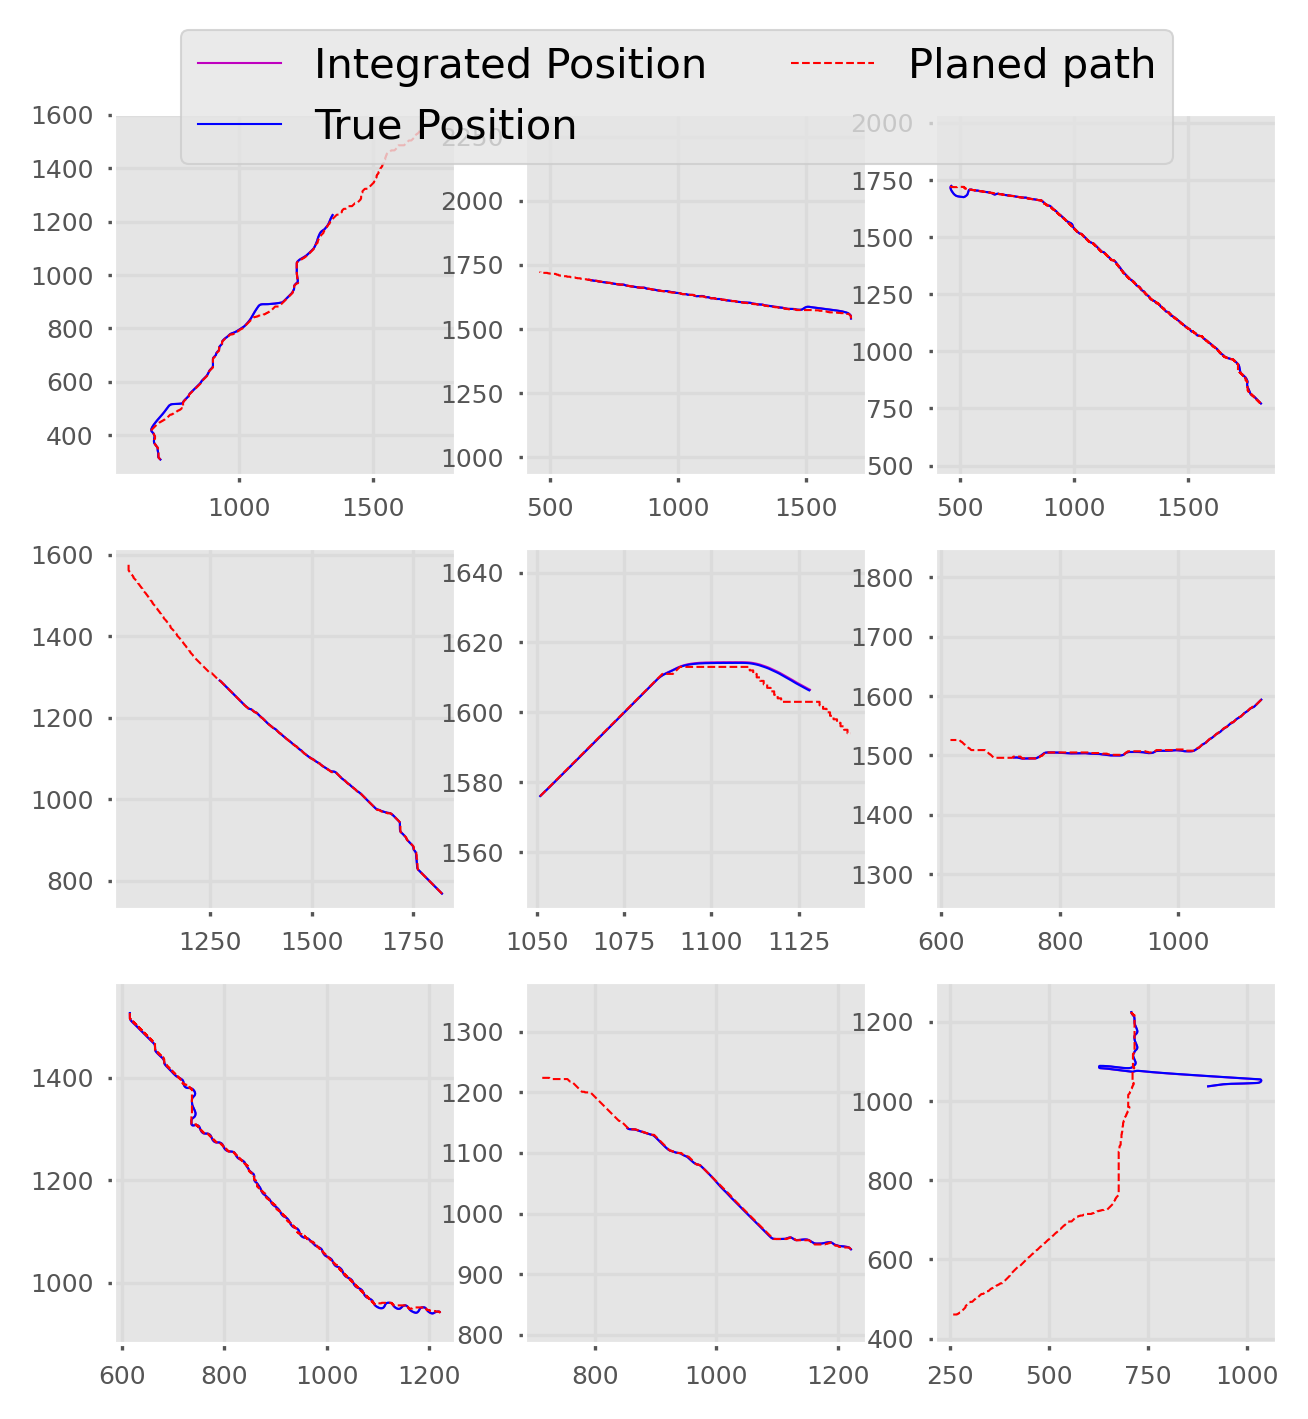

In [7]:
def main():
    config = yaml.load(open("./Datasets/profile.yml"), Loader=yaml.FullLoader)
    config = config["Cities"]
    """Initializing Image"""
    testingCity = "Newyork"
    config = config[testingCity]
    city = config["city"]
    roadmap_filepath = config["roadmap_filepath"]

    img = np.array(Image.open(roadmap_filepath).convert("L"))

    meterWidth = 5000
    pxlPerMeter = img.shape[0] / meterWidth

    img[img < 255] = 0
    img[img == 255] = 1

    """Generate Paths"""
    num_locations = 20
    randomPath_filepath = config["randomPath_filepath"]
    findPathsThroughRandomPoints(img, num_locations, randomPath_filepath)

    """Original"""
    # pathfile='./results/TestEnvironmentFiles/Paths/testEnvPath1_5kmrad_100pdi_0.2line.npy'
    # pathfile='./results/TestEnvironmentFiles/Paths/testEnvMultiplePaths1_5kmrad_100pdi_0.2line.npy'
    # pathfile='./results/TestEnvironmentFiles/Paths/testEnvMultiplePathsSeparate_5kmrad_100pdi_0.2line.npy'

    """Scaled"""

    # print(f"scaled width{np.shape(path_img)[0], np.shape(path_img)[1]}, pxlPerMeter{np.shape(path_img)[0]/meterWidth, np.shape(path_img)[1]/meterWidth}")
    # path= remove_consecutive_duplicates(list(zip(path_x, path_y)))

    # path_x, path_y = zip(*np.load(pathfile,allow_pickle=True)[0])
    # plt.imshow(img, cmap='gray')
    # plt.plot(path_x, path_y, 'r-')
    # plt.grid('off')
    # plt.show()

    """Run Simulation"""
    # runSimulation(path_x, path_y, path_img)

    paths = np.load(randomPath_filepath, allow_pickle=True)

    # for path_num in range(len(paths)):
    for path_idx, path in enumerate(paths):
        simulation_result_file = Path(
            f"Results/TestEnvironmentFiles/TraverseInfo/{city}{path_idx}.npz"
        )
        if not simulation_result_file.parent.exists():
            simulation_result_file.parent.mkdir(parents=True)
        if simulation_result_file.exists():
            print(f"{simulation_result_file} exixts, using existing file ...")
            continue

        scale = 1
        path_x, path_y, scaled_img, path_img, currentPxlPerMeter = rescalePath(
            paths, path_idx, img, scale, pxlPerMeter
        )
        noVisualizationDrive(
            path_x,
            path_y,
            path_img,
            simulation_result_file,
            frames=len(path_x) * 3,
        )

    # paths=np.load(pathfile,allow_pickle=True)
    # scale,index=1,0
    # path_x, path_y, path_img, currentPxlPerMeter= rescalePath(paths, index, img, scale, pxlPerMeter)
    # noVisualisationDrive(path_x, path_y, index, frames=len(path_x)*3)

    """Test Stored Traverse"""
    fig, ax = plt.subplots(3, 3, figsize=(5, 5), dpi=300)
    axs = ax.ravel()
    for index in range(len(paths)):
        path_x, path_y = zip(*paths[index])
        outfile = Path(f"Results/TestEnvironmentFiles/TraverseInfo/{city}{index}.npz")
        traverseInfo = np.load(outfile, allow_pickle=True)
        speeds, angVel, truePos, startPose = (
            traverseInfo["speeds"],
            traverseInfo["angVel"],
            traverseInfo["truePos"],
            traverseInfo["startPose"],
        )

        x_integ, y_integ = pathIntegration(speeds, angVel, startPose)
        x, y = zip(*truePos)

        print(f"err ar {index}")
        print(
            np.sum(np.array(x) - np.array(x_integ)),
            np.sum(np.array(y) - np.array(y_integ)),
        )

        """color dictionary"""
        color = {"A": "m-", "B": "b-"}

        """plot"""
        (l1,) = axs[index].plot(x_integ, y_integ, color["A"], label=f"Label A")
        (l2,) = axs[index].plot(x, y, color["B"])
        (l3,) = axs[index].plot(path_x, path_y, "r--")
        axs[index].axis("equal")
        axs[index].tick_params(axis="x", labelsize=6)
        axs[index].tick_params(axis="y", labelsize=6)
        # axs[i].ticklabel_format(axis='both', style='sci', scilimits=(0,0))

        # plt.plot(path_x, path_y, "r--")
    # fig.suptitle(f"simulation on {city} map")
    plt.subplots_adjust(top=0.93)
    fig.legend(
        (l1, l2, l3),
        (f"Integrated Position", "True Position", "Planed path"),
        loc="upper center",
        ncol=2,
        bbox_to_anchor=(0.5, 1.0),
        prop={"size": 10},
    )
    plt.savefig(f"path_planning_in_{city}.png")


if __name__ == "__main__":
    main()
